# The Timeseries Quantum Autoencoder - Data Exploration
*TS QAE in Qiskit with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - February 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Several approaches to TS data encoding were tested, i.e. unary, binary and anglular.
- Angle encoding was eventually used, with values centered around H state, in the range of [-pi/2..pi/2]
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021
3. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
4. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
5. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
6. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [4]:
%%html
<style>
table {float:left}
</style>

In [5]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *

from matplotlib import set_loglevel
set_loglevel("error")

## Prepare windowed TS data
*Values need to be in [-1..+1] range*

### Prepare time series

In [7]:
### Start random process
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 2022

In [62]:
### Data settings
samples = 500
samples_hi_res = samples*2
split = 1.0

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 12 # tested with: 4(-), 5(-), 6(-), 8(+), 9(-), 10, 12(++)
wind_step = 1
horizon = 1
scale = 1 # 2
pan = 0 # -1

### Noise level
noise_org = 0.1
noise_ts = 0.1

### Location of figures
FIGURES_PATH='figures'

### Utility TS plot

In [66]:
### Plot source data
def qae_plot_source_data(
    X_train, y_train, X_valid, y_valid,
    xlim=None, ylim=None,
    add_markers=True,
    label_suffix=['', '', ''],
    xlabel='Range', ylabel='Target value (deltas)',
    title=f'Differenced TS Windows for Training and Validation',
    sel_wind=None, save_plot=None):

    # Plot the original time series
    plt.rcParams["figure.figsize"] = (6, 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

    # Plot target function
    plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], color='blue', label='All data')
    # plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], color='red', label='Validation')
    # if sel_wind != None:
    #     plt.plot([xt[0] for xt in X_train][104:157], [y[0] for y in y_train][104:157], color='magenta', label='Selected subset')
    if add_markers:
        plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], marker='o', color='lightblue', linestyle='None')
        plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], marker='o', color='pink', linestyle='None')
    plt.legend(loc='lower right', ncol=3)
    if save_plot is not None:
        plt.savefig(save_plot, format='eps')
    plt.show()


### Generate TS with options

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 1000, Split: 1.0, Train Samples: 1000, Valid Samples: 0
Window Size: 12, Step: 1, Horizon: 0
Training Windows: 989, Validation Windows: 0
Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 1000, Split: 1.0, Train Samples: 1000, Valid Samples: 0
Window Size: 12, Step: 1, Horizon: 0
Training Windows: 989, Validation Windows: 0
Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 1000, Split: 1.0, Train Samples: 1000, Valid Samples: 0
Window Size: 12, Step: 1, Horizon: 0
Training Windows: 989, Validation Windows: 0
Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 1000, Split: 1.0, Train Samples: 1000, Valid Samples: 0
Window Size: 12, Step: 1, Horizon: 0
Training Windows: 989, Validation Windows: 0


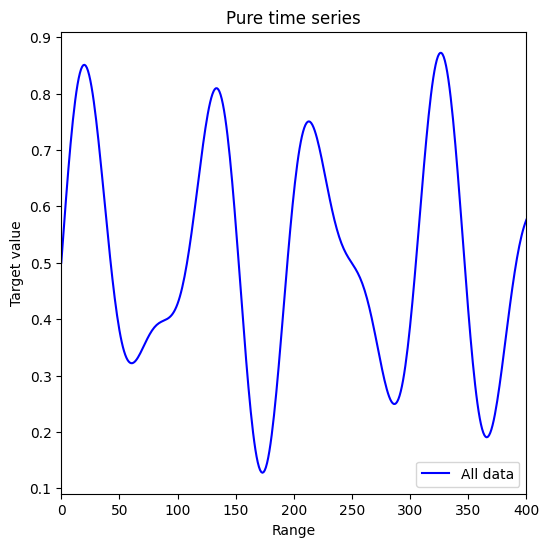

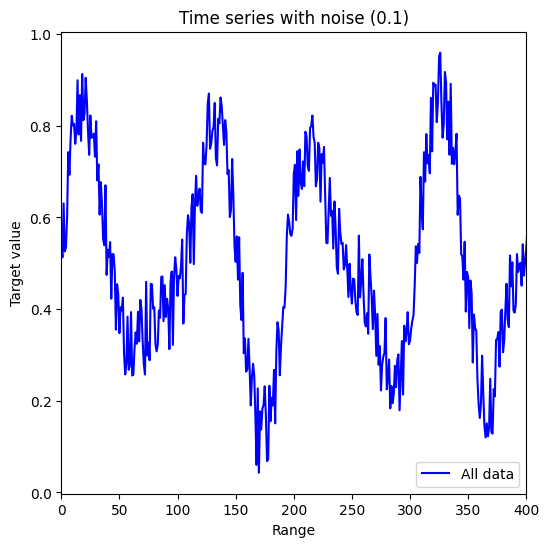

In [67]:
### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

fun_train = Target_2_sins() # Target_beer(pt_from=104, pt_to=156) # Target_2_sins() # Target_poly_3()
sel_wind = 9

X_train_org, y_train_org, X_valid_org, y_valid_org = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=False)

X_train_org_noisy, y_train_org_noisy, X_valid_org_noisy, y_valid_org_noisy = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=False, noise=noise_org)

# fun_train = Target_2_sins()
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=True)

X_train_noisy, y_train_noisy, X_valid_noisy, y_valid_noisy = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=True, noise=noise_ts)

### Plot all TSs
qae_plot_source_data(X_train_org, y_train_org, X_valid_org, y_valid_org, add_markers=False, sel_wind=104, xlim=(0, 400),
                    title='Pure time series', ylabel='Target value', save_plot=f'{FIGURES_PATH}/data_beer_full.eps')
qae_plot_source_data(X_train_org_noisy, y_train_org_noisy, X_valid_org_noisy, y_valid_org_noisy, add_markers=False, xlim=(0, 400),
                    title=f'Time series with noise ({noise_org})', ylabel='Target value')
# qae_plot_source_data(X_train_ts, y_train_ts, X_valid_ts, y_valid_ts, sel_wind=100, add_markers=False,
#                     title=f'Differenced pure time series')
# qae_plot_source_data(X_train_noisy, y_train_noisy, X_valid_noisy, y_valid_noisy, sel_wind=100, add_markers=False,
#                     title=f'Differenced time series with noise ({noise_ts})')


### Utilities

In [91]:
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_city, plot_state_paulivec
from qiskit import Aer

In [92]:
# Converts measurements amplitudes a and b in a|0>+b|1> into bloch vector
def convert_amps_to_xyz(a, b):
    x = 2*np.real(a*np.conjugate(b))
    y = 2*np.imag(b*np.conjugate(a))
    z = a*np.conjugate(a)-b*np.conjugate(b)
    return [x, y, z] 

### Angle encoding
Deltas between consecutive time series values have been angle encoded. In the context of a quibit representation (see the Figure), the encoding assumes zero to be encoded as H state, negative values to be rotations up, while positive values as rotations down. This encoding allows cumulative sequence calculations and easy value decoding upong the qubit measurements. Should there be huge voilatility in data, additional scaling has been added to shrink the region of valid angular qubit positions. 

<div>
    <!--img src="attachment:qae_fig2_wide.png" width="1000"-->
    <img src="../images/seq-value-encoding.png" width="300">
</div>

**Figure: Sequence value coding as qubit angular rotations**

In [93]:
### Angle encoding of a TS value relative to the previous value
#   val: value in [-1..+1] range to be encoded
#   optional scaler=np.pi/2: Number scaler 
#   optional err_range=0/0.05: allows range scaling to cater for accumulating errors
#   returns: Encoding of the next value relative to the previous value
def ts_relang_encode_val(val, scaler=np.pi/2, err_range=0):
    return val * scaler * (1 - 2 * err_range)

### Decoding
def ts_relang_decode_val(val, scaler=np.pi/2, err_range=0):
    return val / (scaler * (1 - 2 * err_range))

### Normalises the value to 1 (not required with angle encoding)
def ts_relang_norm_val(next_code):
    norm_code = next_code
    return norm_code

### Print encoding and decoding for testing
def print_ts_relang_encode_val(n):
    val = round(ts_relang_encode_val(n), 3)
    if val == 0:
        print(f'{(n)} -> {val} (π*{0.0})')
    else:
        print(f'{(n)} -> {val} (π/{round(np.pi / val, 3)})')
    
def print_ts_relang_decode_val(n):
    if n == 0:
        print(f'{round(n, 3)} (π*{0.0}) -> {ts_relang_decode_val(n)}')
    else:
        print(f'{round(n, 3)} (π/{round(np.pi / n, 3)}) -> {round(ts_relang_decode_val(n), 3)}')

def print_ts_relang_norm_val(p):
    print(f'{round(p, 3)} -> {round(ts_relang_norm_val(p), 3)}')

### Test
# print('Encoding:')
# print_ts_relang_encode_val(0)
# print_ts_relang_encode_val(0.5)
# print_ts_relang_encode_val(0.7)
# print_ts_relang_encode_val(0.25)
# print_ts_relang_encode_val(1.2) # Out of [0..pi] range
# print_ts_relang_encode_val(-0.7) # Out of [0..pi] range

# print('\nDecoding:')
# print_ts_relang_decode_val(np.pi)
# print_ts_relang_decode_val(0*np.pi)
# print_ts_relang_decode_val(np.pi/4)
# print_ts_relang_decode_val(-np.pi/2)
# print_ts_relang_decode_val(np.pi/8)
# print_ts_relang_decode_val(-0.9*np.pi) # Out of [0..pi] range

# print('\nNormalise Encoding:')
# print_ts_relang_norm_val(1.5*np.pi)
# print_ts_relang_norm_val(-0.5*np.pi)

In [94]:
### Encoding the entire data set
def ts_relang_encode(wind_set, scaler=np.pi):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_relang_encode_val(val, scaler)
            encoded_wind.append(encoded_val)
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_relang_decode(org_wind_start, encoded_wind_set, scaler=np.pi):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_relang_decode_val(encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### In agle encoding, encoded data is already normalised
def ts_relang_norm(encoded_wind_set):
    return np.array(encoded_wind_set)

### Preparing data for training and testing

In [95]:
### Encoding of TS windows which are 
y_train_enc, org_train_start = ts_relang_encode(y_train_ts)
y_valid_enc, org_valid_start = ts_relang_encode(y_valid_ts)

y_train_noisy_enc, org_train_noisy_start = ts_relang_encode(y_train_noisy) 
y_valid_noisy_enc, org_valid_noisy_start = ts_relang_encode(y_valid_noisy)

### Testing validation windows

# y_train_dec = ts_relang_decode(org_train_start, ts_relang_norm(y_train_enc))
# print('\nTraining windows before encoding:\n', y_train_ts[5:8])
# print('\nTraining windows after encoding:\n', y_train_enc[5:8])
# print('\nTraining windows org start:\n', org_train_start[5:8])
# print('\nTraining windows after decoding:\n', y_train_dec[5:8])

# y_valid_dec = ts_relang_decode(org_valid_start, y_valid_enc)
# print('\nValidation windows before encoding:\n', y_valid_ts[0:8])
# print('\nValidation windows after encoding:\n', y_valid_enc[0:8])
# print('\nValidation windows org start:\n', org_valid_start[0:8])
# print('\nValidation windows after decoding:\n', y_valid_dec[0:8])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


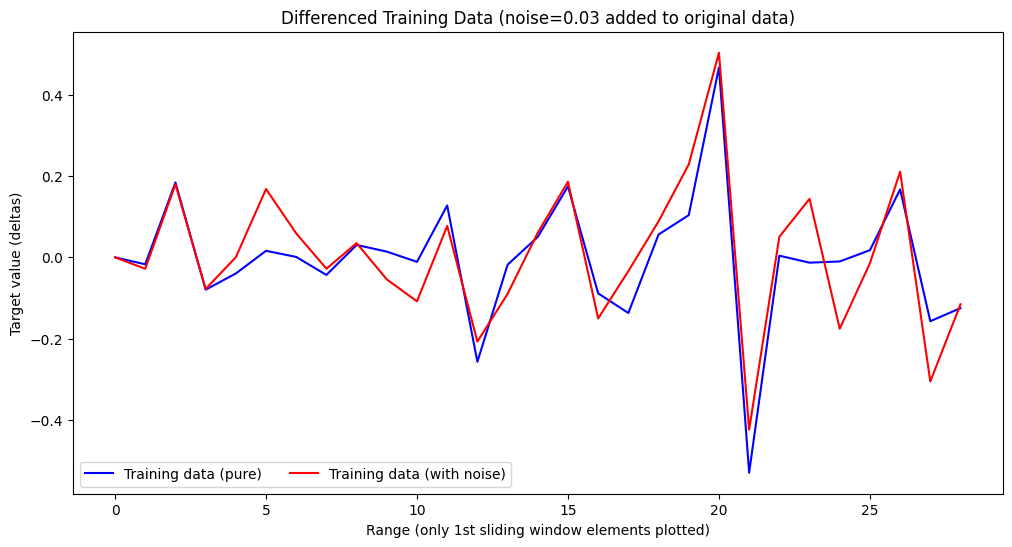

In [100]:
# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title(f"Differenced Training Data (noise={noise_ts} added to original data)")
plt.xlabel("Range (only 1st sliding window elements plotted)")
plt.ylabel("Target value (deltas)")

sel_range=range(len(y_train_enc))
#sel_range=range(70, 100, 1)
#sel_range=range(10, 40, 1)

plt.plot(list(sel_range), [y[0] for y in y_train_enc[sel_range]], color='blue', label='Training data (pure)')
plt.plot(list(sel_range), [y[0] for y in y_train_noisy_enc[sel_range]], color='red', label='Training data (with noise)')
plt.legend(loc='lower left', ncol=2)
plt.savefig(f'{FIGURES_PATH}/data_beer_differenced_training.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


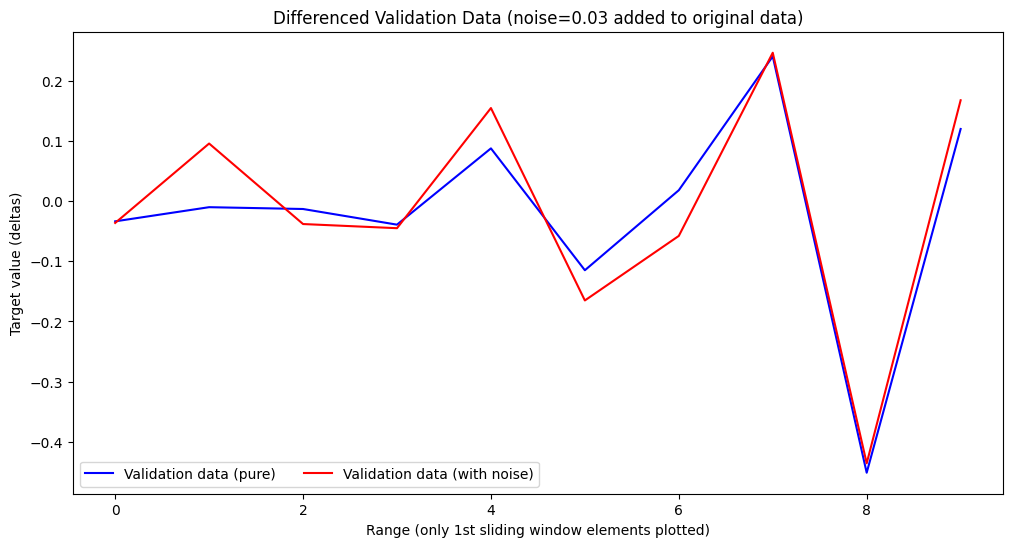

In [101]:
# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title(f"Differenced Validation Data (noise={noise_ts} added to original data)")
plt.xlabel("Range (only 1st sliding window elements plotted)")
plt.ylabel("Target value (deltas)")

sel_range=range(len(y_valid_enc))
#sel_range=range(70, 100, 1)
#sel_range=range(10, 40, 1)

plt.plot(list(sel_range), [y[0] for y in y_valid_enc[sel_range]], color='blue', label='Validation data (pure)')
plt.plot(list(sel_range), [y[0] for y in y_valid_noisy_enc[sel_range]], color='red', label='Validation data (with noise)')
plt.legend(loc='lower left', ncol=2)
plt.savefig(f'{FIGURES_PATH}/data_beer_differenced_validation.eps', format='eps')
plt.show()

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

## Performance Statistics
The format of the presented statistics was evolving over time. In the current edition, which is most evident in the reporting for the experiments running on the "furies-vengence" machine, the reported details include:
- device: Device used to accelerate computation (GPU/CPU)
- samples: Number of samples used in training (numeric)
- reps: Number of repeated blocks in ansatz (numeric)
- ent: Entaglement type (linear, reverse_linear, full, circular, sca, pairwise)
- qubits l+t: Number of core ansatz qubits used in QAE testing (numeric latent + trash qubits)
- params: Number of trainable parameters (numeric)
- epoch: Number of training iterations (numeric)
- min cost: Minimum cost achieved in circuit optimisation (numeric)
- sec: Elapsed time in seconds used in circuit training (numeric)
- R2: R squared providing goodness of fit between the TS window and its reconstruction (0..1)
- Trim l+r: R2 measure between windows trimmed to deal with edge distortion (numeric left + right)
- comment: Additional remark on the experiment's success (e.g. "Promissing" or "Disappointing")
- colour: Colour siginfying the "goodness" of selected experiment's controls (blue=great, red=terrible, magenta=note this, black=FYI)

### furies-vengence: ASUS 64Gb RAM
- CPU Intel i9, 24 cores, 32 threads, 2.2-3.0-4.3-5.4GHz
- GPU NVIDIA GTX 4090, 16384 CUDA Cores, 24 Gb RAM, CUDA V12.3, NVIDIA Driver 545.29.06

**Half-QAE Training**

<font color="blue">GPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 300 epochs):</font> **0.00301 min cost, 98.32 sec** (R2=0.815, Trim 0+2 R2=0.984, Promising)<br/>
<font color="blue">GPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs):</font> **0.00305 min cost, 65.55 sec** (R2=0.838, Trim 0+2 R2=0.986, Promising)<br/>
<font color="green">GPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs):</font> **0.03907 min cost, 57.87 sec** (R2=0.764, Trim 0+2 R2=0.967, Test Cost=1-P(|0>^t, no swap))<br/>
<font color="magenta">CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs):</font> **0.00379 min cost, 146.40 sec** (R2=0.785, Trim 0+2 R2=0.976, CPU is 0.45 of GPU speed)<br/>
<font color="blue">GPU Fit (274 samples, 4 reps, "sca" ent, 8+2 qubits, 50 params, 600 epochs):</font> **0.0039 min cost, 236.92 sec** (R2=0.745, Trim 1+1 R2=0.975, Promising)<br/>

**Full-QAE Training**

GPU Fit (135 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.02601 min cost, 6582.02 sec** (Train: Pure->Pure, Enc/Enc-dg only, Opt to Zero)<br/>
&emsp;&emsp;Match: Pure vs Pure (R2=0.707, Trim 0+2 R2=0.923)<br/>

GPU Fit (135 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.03173 min cost, 6689.22 sec** (Train: Noise->Pure, Enc/Enc-dg only, Opt to Zero)<br/>
&emsp;&emsp;Match: Pure vs Pure (R2=0.768, Trim 0+2 R2=0.989) / Noise vs Noise (R2=0.767, Trim 0+2 R2=0.988) / Noise vs Pure (R2=0.563, Trim 0+2 R2=0.721)<br/>

GPU Fit (135 samples, 2 reps, "sca" ent, 5+3 qubits, 24 params, 200 epochs): **0.03461 min cost, 6770.68 sec** (Train: Noise->Pure, Enc/Enc-dg only, Opt to Zero)<br/>
&emsp;&emsp;Match: Pure vs Pure (R2=0.653, Trim 0+2 R2=0.841) / Noise vs Noise (R2=0.658, Trim 0+2 R2=0.843) / Noise vs Pure (R2=0.509, Trim 0+2 R2=0.66)<br/>

GPU Fit (135 samples, 2 reps, "sca" ent, 4+4 qubits, 24 params, 200 epochs): **0.04668 min cost, 7057.43 sec** (Train: Noise->Pure, Enc/Enc-dg only, Opt to Zero)<br/>

GPU Fit (135 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.06584 min cost, 3874.71 sec** (Train: Noise->Pure, Enc/Enc-dg only, Opt to P(|0>^8))<br/>
&emsp;&emsp;Match: Pure vs Pure (R2=0.766, Trim 0+2 R2=0.995) / Noise vs Noise (R2=0.774, Trim 0+2 R2=0.994) / Noise vs Pure (R2=0.536, Trim 0+2 R2=0.698)<br/>

GPU Fit (135 samples, 2 reps, "sca" ent, 6+2 qubits, 48 params, 200 epochs): **0.15521 min cost, 3592.66 sec** (Train: Noise->Pure, Enc/Dec-dg, Opt to P(|0>^8))<br/>
&emsp;&emsp;Epochs 1-200 epocha: Pure vs Pure (R2=0.297, Trim 0+3 R2=0.553) / Noise vs Noise (R2=0.36, Trim 0+3 R2=0.612) / Noise vs Pure (R2=0.165, Trim 0+3 R2=0.398)<br/>
GPU Fit (135 samples, 2 reps, "sca" ent, 6+2 qubits, 48 params, 200 epochs): **0.08664 min cost, 3891.44 sec** (Train: Noise->Pure, Enc/Dec-dg, Opt to P(|0>^8))<br/>
&emsp;&emsp;Epochs 201-400 epocha: Pure vs Pure (R2=0.696, Trim 0+3 R2=0.906) / Noise vs Noise (R2=0.702, Trim 0+3 R2=0.913) / Noise vs Pure (R2=0.558, Trim 0+3 R2=0.742)<br/>

<font color="blue">GPU Fit (29 samples, 2 reps, "sca" ent, 6+2 qubits, 48 params, 500 epochs):</font> **0.05421 min cost, 2116.93 sec**  (Train: Noise->Pure, Enc/Dec-dg, Opt to P(|0>^8))</br>
&emsp;&emsp;training: Noise vs Pure (R2=0.713, Trim 0+2 R2=0.609), validation: Noise vs Pure (R2=0.703, Trim 0+2 R2=0.722, Promising)<br/>


**Earlier Half-QAE Training**

GPU Fit (275 samples, 2 reps, "linear" ent, 6+2 qubits, 24 params, 200 epochs): **0.00884 min cost, 65.01 sec** (R2=404, Trim R2=NA)<br/>
GPU Fit (275 samples, 2 reps, "circular" ent, 6+2 qubits, 24 params, 200 epochs): **0.014 min cost, 64.83 sec** (R2=-0.303, Trim R2=NA)<br/>
GPU Fit (275 samples, 2 reps, "pairwise" ent, 6+2 qubits, 24 params, 200 epochs): **0.00629 min cost, 54.41 sec** (R2=0.509, Trim 0+4 R2=0.986)<br/>
GPU Fit (275 samples, 2 reps, "full" ent, 6+2 qubits, 24 params, 200 epochs): **0.00556 min cost, 68.24 sec** (R2=0.716, Trim 0+3 R2=0.971)<br/>
GPU Fit (275 samples, 3 reps, "sca" ent, 6+2 qubits, 32 params, 300 epochs): **0.005 min cost, 101.94 sec** (R2=0.766, Trim 2 R2=0.98, Promising)<br/>
GPU Fit (274 samples, 2 reps, "sca" ent, 8+2 qubits, 30 params, 400 epochs): **0.00459 min cost, 140.45 sec** (R2=0.716, Trim 2 R2=0.76)<br/>
GPU Fit (274 samples, 3 reps, "sca" ent, 8+2 qubits, 40 params, 500 epochs): **0.00621 min cost, 182.33 sec** (R2=0.814, Trim 2 R2=0.872)<br/>
GPU Fit (274 samples, 4 reps, "sca" ent, 8+2 qubits, 50 params, 400 epochs): **0.00404 min cost, 157.36 sec** (R2=0.715, Trim 1+1 R2=0.971)<br/>
GPU Fit (274 samples, 4 reps, "circular" ent, 8+2 qubits, 50 params, 600 epochs): **0.01182 min cost, 243.13 sec** (R2=0.435, Trim R2=NA)<br/>
GPU Fit (274 samples, 4 reps, "pairwise" ent, 8+2 qubits, 50 params, 600 epochs): **0.00751 min cost, 224.47 sec** (R2=0.629, Trim 0+4 R2=0.857)<br/>


### basilisk: Lenovo 32Gb RAM
- CPU Intel i7, 4 cores, 8 threads, 2.8GHz - No GPU

CPU Fit (110 samples, 6+2 qubits, 32 params): **0.00744 min cost, 226.05 sec**<br/>
CPU Fit (275 samples, 6+2 qubits, 32 params, 400 epochs): **0.00512 min cost, 797.54 sec**<br/>
CPU Fit (275 samples, 6+2 qubits, 32 params, 250 epochs): **0.00623 min cost, 531.32 sec**<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 250 epochs):</font> **0.00314 min cost, 308.64 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00407 min cost, 155.59 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00684 min cost, 157.55 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00329 min cost, 154.95 sec** (Bravo-Prieto - terrible)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00359 min cost, 284.36 sec** (R2=-6.629, Trim 0+3 R2=-1.783, Test 2)<br/>

### goblin-galore: Tomahawk 64Gb RAM
- CPU Intel i7, 6 cores, 12 threads, 3.5GHz - 2 GTX NVIDIA 1080 T1 GPUs, CUDA V12.2, NVIDIA Driver 535
- Note that this GPU at 6.1 compute capability is not compatible with Qiskit (cuQuantum requirement: +7 compute capability)

CPU Fit (275 samples, 6+2 qubits, 32 params, 400 epochs): **0.00456 min cost, 695.26 sec**<br/>
CPU Fit (274 samples, 8+2 qubits, 40 params, 400 epochs): **0.00364 min cost, 2430.50 sec** (Promising)<br/>
CPU Fit (274 samples, 6+3 qubits, 45 params, 500 epochs): **0.00907 min cost, 3603.48 sec** (Disappointing)<br/>
CPU Fit (275 samples, 5+3 qubits, 40 params, 300 epochs): **0.02233 min cost, 731.32 sec** (Disappointing)<br/>
CPU Fit (275 samples, 5+3 qubits, 40 params, 300+100 epochs): **0.01913 min cost, 245.12 sec** (Disappointing)<br/>
CPU Fit (275 samples, 6+2 qubits, 24 params, 300 epochs): **0.00334 min cost, 453.17 sec** (Promising, Test 0)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00364 min cost, 309.03 sec** (R2=0.655, Trim 0+2 R2=0.934, Test 1 - Trig vs other Trig)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00364 min cost, 313.68 sec** (R2=-11.302, Trim 0+3 R2=-1.033, Test 2a - Trig vs Poly)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00014 min cost, 296.56 sec** (R2=-10.004, Trim 0+2 R2=-0.94, Test 2b - Poly vs Poly)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 160 epochs): **0.00044 min cost, 236.67 sec** (R2=-12.575, Trim 0+2 R2=-0.874, Test 2c - Poly vs Poly, short)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00752 min cost, 305.49 sec** (R2=0.749, Trim 0+2 R2=0.992, Test 3 - Jitter vs Trig)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00014 min cost, 306.52 sec** (R2=-8.721, Trim 0+2 R2=-1.014, Test 4a - Linear vs Linear)<br/>
CPU Fit (274 samples, 2 reps, "sca" ent, 8+2 qubits, 30 params, 200 epochs): **9e-05 min cost, 987.61 sec** (R2=-8.5, Trim 0+2 R2=-5.671, Test 4b - Linear vs Linear)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.01954 min cost, 305.30 sec** (R2=0.758, Trim 0+2 R2=0.954, Test 5 Beer)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 5+3 qubits, 24 params, 200 epochs): **0.03795 min cost, 340.04 sec** (R2=0.575, Trim 0+2 R2=0.717, Test 6 Beer)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 4+4 qubits, 24 params, 200 epochs): **0.06599 min cost, 872.53 sec** (R2=0.201, Trim 2+2 R2=0.349, Test Summary Beer)<br/>


## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - Issue 01 (Completed) *Not sure how to interpret the output - cannot be visual*
          - Issue 02 (Completed) *Visual match between input and output not close*
          - Issue 03 (Completed) *Noise needs to be injected in training*
          - Issue 04 (Completed) *Training is getting slow, need to use GPU*
          - Issue 05 (Completed) *It is worth testing if an increase of the latent or trash layers could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2 Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,<br/>
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.
      - Several problems installing GPU support, attempt to address Issue 04
          - Issue 06 (Completed) *Several problems associated with GPU support*<br/>
          - **Fix 06** *Need to install ML 0.7.1+ and Aer 0.13.2+*<br/>
            ML 0.7.1 standard installation (no need to install from source anymore)<br/>
            Aer 0.13.2 requires CUDA + cuQuantum + cuTensor (Deb)<br/>
            - Note that Aer Sampler has a bug and will not work with RawFeatureVector.
          - **Fix 04** *With GPU the training speed increased ~2 times
    - V2.3 Attempt to move to PuTorch, abandoned for the time being
    - V2.4 Changing to angle encoding - relative with Ry over 2pi
      - Issues noted:
          - Issue 07 (Completed) *Negative numbers not coded properly*</br>
      - Action planned:
          - *Change encoding as relative from H over pi* - with [-1:0] pi/2 negatives towards |0> and [0:+1] pi/2 positives towards |1>
    - V2.5 Completed QAE with angle encoding, lots of fixes
      - Fixes completed:
          - **Fix 07** *Adopted encoding around H state, up negative, down positive*
          - **Fix 02** *Resulting QAE outputs better match the inputs*
          - **Fix 01** *With the new encoding, the output is easy to interpret*
      - Issues noted:
          - *Issue 08* (Partially Completed) *QAE reconstruction has large variance end of windows*, averaging overlapping windows may help
          - Issue 09 (Completed) *Need to reconstruct the entire series*, possibly with averaging of overlapping windows
      - Action planned:
          - Issue 10 (Completed) *Systematically experiment with:* data sets, window size, step size, trash size, qubit no, ansatz reps and entanglement type
    - V2.6 Testing various QAE configurations
      - Varied the number of qubits (8 was best) and asatz reps (4 was best)
      - Issues noted:
          - Issue 11 (Completed) *Random seed seems to have little effect on results*
          - Issue 12 (Completed) *QAE results tend to be close to zero at the window ends, e.g. 1st and 7th value [0..7]*
          - Issue 13 (Completed) *Related to #12, the first window value should not be zero but the diff with the value from the previous window*<br/>
            Change the order of processing - first create deltas, then split into windows, change TS value encoding and decoding (no need to delta)
    - V2.7 Testing with an older computer Tomahawk, 64Gb RAM, 2 x GeForce GTX 1080 Ti, also testing the enhance encoding of Bravo-Prieto [4]
      - Issues noted:
          - Issue 14 (Completed) *GPU failed with error:*<br/>
            Simulation failed and returned the following error message:<br/>
            ERROR:  [Experiment 0] This program was not compiled for SM 61<br/>
          - Issue 15 (Completed) *A series of experiments with Bravo-Prieto's algorithm failed to produce any results*
      - Fixes completed:
          - **Fix 14** Reason (as provided on Slack), CuQuantum does not support GTX 1080 GPUs (cat.SM 61) - may not be fixable, GPU too old
          - **Fix 15** Bravo-Prieto algorithm could not be reproduced in any form, and with all possible options - it was abandoned*
      - CPU run works well - faster than Lenovo, results are pretty good (as per V2.6)
    - V2.8 Fixed incorrect coding of the first window value
      - Fixes completed:
          - **Fix 11** *Added **seed-simulator** to the backend options for GPU, this may be added for CPU when using AerSampler for CPU*
          - **Fix 12-13** *The first window encoded value is now delta of the first value minus the last value from the previous window*<br/>
            This was achieved by encoding the entire time series first, before splitting it into windows<br/>
            Additional charts were provided to show the original data, encoded sequence, and testing sequence<br/>
            QAE results at the edges of a window are non zero
      - Issues notes:
          - Issue 16 (Completed) *Noted high accuracy of results in the middle of windows, however, the edges are distorted* - related to Issue 08 and issue 12.<br/>
            The causes of this phenomenon may be: (1) the ansatz entanglement strategy, (2) position of Swap Test and recovery of the trash space, or (3) the sequential presentation of input.<br/>
            A possible approach would be to shuffle data on input, move the position of the trash to the middle, or to reject the values on edges.<bt/>
            To test this we need to experiments with larger windows
    - V2.9 Tested QAE with windows of size 10 - great results
      - Fixes completed:
          - Fix 08 (Completed) *When testing with windows of size 8 and 10, the edge inaccuracy persists but shifts*<br/>
            This may be the feature of the approach with Swap Test training
      - Action planned:
        This run was saved and the generated parameters and data will be used to address **Issue 9** (reconstruction of the series)
    - V2.10 Started a cleanup of all code
      - A test was conducted to create a QAE with 5/6 latent and 3 trash qubits. Its results were disappointing. The notebook, however, was copied to the Runs folder.
    - V2.11 Finished cleanup
    - V2.12 Adding precision stats of QAE results - R2, RMS, MAE and MAPE, with optional edge trimming of windows to increase precision
    - V2.13 Extendend the cost function, now part of the class "Cost"<br/>
      - Work conducted:
          - Implemented class "Cost", which allows parameterisation of the function behaviour.
          - Attempt 16 (Fully experimented) with the following results:
            - *Implemented shuffling of data durinug training, but there was no impact on the edge distortion*
            - *Tested variety of entanglement options, "sco" was found to be the best, other strategies produced distortions elsewhere and inferior results, so this may still be the culprit*
            - *Position of the trash space (and the Swap Test) seems to coincide with the edge distortion, so it could be its cause - needs a separate experiment*
    - V2.14 Merging all QAE test windows into a single time series (considering windows step and edge trimming)
      - Fixes completed:
        - **Fix 05** Experimented with different size of trash / latent area were conducted. with different outcomes, as reported.
        - **Fix 08, 16** The edge distortion is possibly linked to the choice of the ansatz, which moves the majority of variance to the edges.
          However, elimination of qubits causing distortion may in fact act contrary tothe very idea of QAE restoring the entire range of values in
          both latens and trash area. So this must be done with caution.
        - **Fix 09** The full series can now be reconstructured, with averaging of overlapping windows, and taking into consideration of window trimming.
        - **Fix 10** The systematic tests of the QAE has commensed and will continue.
    - V2.15 Test Summary, includes comments on Test 1, Test 2, ..., Test 6, and the Summary notebook
      - Observations:
        - The previous tests (such as v2.14_merged_ts), focused primarily on perfecting QAE where the trainnig and test sets were drawn from the same data sample.
          It seemed that the recovered input patterns had some edge distortion, i.e. increase in variance near qubit 0 and max, removal of which greatly improved the QAE accuracy.
          What was not obvious at the time was the fact that the distortion would most commonly occur in the trash area.
          This also means that by trimming the trash-related window components carried the majority of noise, and with a small trash area, the latent area was trained to approximate an identity.
        - In Test 1, the training sample and a test data were drawn from different sample types, however, both were of an oscillating nature, but of a different complexity and amplitude.
          The initial intuition indicated that the recovered data would match the patterns occuring in training data. However, all data recovered would match that of a test data sample -
          this is what QAE is in fact supposed to do.
        - Test 2a was further testing the hypothesis that QAE would recover the patterns present in a test sample. However, when the types of training and test samples are significantly different, i.e.
          sinusuidal and polynomila (almost linear differences betweel data points), the QAE had difficuties replicating the polynomial input. This could possibly be attributed to the QAE input coding
          which consisted of qubit rotations, and which favour Fourier style of data processing rather than that typical of regression or polynomial data analysis.
          The Test 2b seems to indicate that the QAE is not suitable for learning linear relationships, inspite of excellent cost achieved at the end - note that Test 2c excludes overtrainnig.
          It is also worth noting the errors generated by simply measuring the near-linear windows data, their R2 is as low (negative!) as that of the recovered signal!
        - Test 3 further confirmed the QAE ability to correctly recover test data, as long as the training data matched its type. However, having used the random oscillations in training
          data, it was a great surprise to see the QAE abillity to correctly recover test data. The hypothesis at this point of time was that QAE, without any intelligence, simply replicates i
          qubits spanning the latent area.
        - Test 4 again looked at polynomial data with near-linear test set. The results show very poor alignment (in terms of R2) between the orginal (but differenced) data and its recovered input.
          As before in Test 2, it showed that the error generated by QAE for input recovered on output is of the same magnitude as that generated by the circuit consisting of encoded input alone.
          The variance of measured input and the output values around the expected windows values look dramatic, however, this is illusory as the default y range in the chart is very small.
          It is worth noting that when looking at the results in the scale of the original data, their MAE and RMS are relatively small.
        - Tests 5, 6 and 7 aimed to verify whether or not the QAE was able to abstract the patters learnt from the training data and transfer this knowledge to test data.
          Data used for these experiments involved the USA beer sales over several weeks. In the tests, the trash area was progressively enlarged from 2 qubits (leaving 6 qubits in a latent area),
          to 3 (with 5 latent qubits) and then 4 (with 4 latent qubits). It was evident that the QAE was able to approximately recover the input, however, the errors would enlarge (as evidenced by
          R2, RMSE, MAE and MAPE measurement).
        - Test 8 was conducted to ensure that the latent space did not simply produce a copy of the input, which was found not to be the case.
        - <font color="green">Test 9 was to replace swap test with in-line test and a new cost function cost=1-P(|0>^t) where t is the size of trash. The approach resulted in faster execution but lower accuracy.</font>
        - In summary, the QAE works well. It is able to abstract training data, to allow recovery of previously unseen input data on its output. It is the richness of training data set, which determines
          the accuracy of QAE processing with test data, rather than the similarity of the two data sets. However, a completely different types of samples used in training and testing (such as
          oscillating vs linear) will prevent QAE to perform with any degree of accuracy.
    - V2.16 Development of the full-QAE which could then be used to support noise elimination, and allow the full input vs output comparison
      - Issues noted:
          - **Issue 17** Training of the full-QAE is ***50 times slower*** than of the half-QAE.
            The reasons for this is probably due to the Swap Test on 8 qubits rather than on just the trash space.
            Another likely reason is that the Swap Test is comparing arbitrary states rather than |0> states.
            Note that a Swap Test may not be effective when the states are close to |+>, which is our encoding of zero
            (see Siegelwax, B.N., 2020. The Simplest Way to Compare Single-Qubit Quantum States. Medium).
            A more efficient swap test may need to be used. Two possible solutions are considered at this stage:<br/>
            (1) train the model in two stages (first as half-QAE for noisy data, then as full-QAE for noisy vs clean data);<br/>
            (2) use a destructive swap on one qubit for state swapping and one ancilla for collection and measurement;<br/>
            (3) somehow reduce comparison of arbitrary states to zero states.e.g. by rotating all qubits back and then checking for |0>.
    - V2.17 Full-QAE with de-noising
      - Tests completed:
          - Value scaling was tested, large interval generates incorrect TS
          - Using full-QAE as a simple encoder S(x) A(x) S(x) with Swap Test to zero works, however, results are not as good as with half-QAE.
          - Three tests conducted to test the full-QAE performance with varying sizes of latent space, i.e. 2.17a (6+2), 2.17b (5+3), 2.17c (4+4)
      - Issues noted:
          - Issue 18 (Completed) Noise embedded in a circuit is not edequate as it is fixed for the entire duration of training.
            Noise needs to vary for all instances of training data instead.
          - Issue 19 (Completed) Scaling of pure and noisy signals seems to be incorrect, noise seems to have reduced amplitude of the signal.
            At the moment noise is added to the original signal. However, after differencing it seems to be distorted - this will affect the work of QAE in denoising.
            Perhaps noise needs to be added after differencing, so that it is not subtracted or amplified?
          - Issue 20 (Completed) At the moment the full-QAE incorrectly implements a decoder as an encoder-dag, it should be a separate block with its own parameters,
            which unfortunately will double execution time and slow it even more.
          - Issue 21 (Completed) Full-QAE does not learn to produce clean data from noisy data, it seems to pass noise from input to output.
            This may be related to the fact that optimisation error is higher than the discrepancy between noisy and pure data.
          - Issue 22 (Completed) Replace the expensive QAE cost function, with a simple P(|0>^n), which can be calculated as the count of all zeros / number of shots.
            Idea - aim is to maximise zeros, so measure all qubits, in cost function collect result of forward, check result[0] (all zeros), max this!
      - Fixes completed:
          - **Fix 03, 18** Now the noise is injected into the TS itself for training or testing
          - **Fix 19** Scaling to interval (-1, 1) results in incorrect interpretation of measurements (due to encoding), should not be attempted.
            Scaling with (-0.5, +0.5) works better.
    - V2.18 Full-QAE with de-noising and new cost function cost=1-P(|0>^q) (q=the number of qubits)
      - Observations:
          - The new full-QAE is twice as fast
          - It takes half the number of qubits
          - It is marginally less accurate
          - Does not address issue 21 (and possibly 20)
      - Fixes completed:
          - **Fix 22** The new cost function cost=1-P(|0>^q) (q=the number of qubits) has been implemented and tested.
    - V2.19 Full-QAE has a separate encoder and decoder
      - Observations:
          - The new full-QAE with separate encoder/decoder performs slightly better than encoder/encoder-dg
          - It is still unable to reproduce good TS from bad ones (issue 21), perhaps it needs on input a mix of good and noisy data.
      - Fixes completed:
          - **Fix 20** Full-QAE encoder is followed by an independent decoder-dg, same structure as encoder but in reverse order with different parameters.
    - V2.20 Implemented a new cost function which counts the number of 1s in measurements, aiming to eliminate them
      - Observations:
          - The optimisation very rapidly converges to lower values
          - However, it takes lots of iterations to achieve minimum
          - However, the minimum does not seem to be what is needed
          - The reconstructed curve is not changing much
    - V2.21 Going back to cost function 1-P(|0>^n), drastic reduction in data samples used for QAE training and validation
      - Observations:
          - Data sample was reduced to 29 examples for training and 10 for validation
          - The model seems to train quicker and smoother but requires more iterations (500)
          - The model actually generalises away from its training data and learns pure data from noise
          - Performance metrics are reasonable but not great
          - Much better results than before
      - Fixes completed:
          - **Fix 21** The model learns to reconstruct pure data windows from noisy data
      - Future work:
          - Test the model performance on other (simpler) data sets
          - Test the model performance with the cost function minimising the 1s in measurements
          - Try pretraining the encoder with half-QAE and stage decoder training (this may improve the training speed and address the only outstanding **Issue 17**)

# Software in use

In [64]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0


In [65]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright